## Nitrate 20 m and below

In [1]:
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import pandas as pd
import statsmodels.api as sm
import xarray as xr

In [114]:
foramt = "{:.2}"
myformat = {'bias': foramt, 'rmse': foramt, 'swillmott': foramt, 'slopedev': foramt, 'const': foramt,
                         'systematic': foramt, 'nonsystematic':foramt, 
                    'spread': foramt}
def use_f_2(x):
    return "%.2f" % x

In [3]:
with xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask201702.nc') as mesh:
    deptht = mesh.gdept_1d[0].values

In [4]:
def bias(df, obs, mod):
    diffy = df[mod] - df[obs]
    return diffy.count(), diffy.mean()

In [5]:
def rmse(df, obs, mod):
    return (np.sqrt(((df[mod] - df[obs])**2).mean()))

In [6]:
def swillmott(df, obs, mod):
    meanobs = df[obs].mean()
    return (((df[mod] - df[obs])**2).sum()
            /(( (df[mod] - meanobs).abs() + (df[obs] - meanobs).abs() )**2).sum())

In [7]:
def slope_inter(df, obs, mod):
    X = df[obs]
    y = df[mod]
    X = sm.add_constant(X)

    # Fit and make the predictions by the model
    model = sm.OLS(y, X, missing='drop').fit()
    predictions = model.predict(X)
    
    nonsyst = np.sqrt(((y - predictions)**2).mean())
    systematic = np.sqrt(((predictions - df[obs])**2).mean())
    return model.params[obs], model.params['const'], systematic, nonsyst

In [8]:
def spread(df, obs, mod):
    return 1 - ((df[mod] - df[mod].mean())**2).mean() / ((df[obs] - df[obs].mean())**2).mean() 

In [9]:
def read_pieces(pieces):
    temp1 = pd.read_csv(pieces[0])
    for piece in pieces[1:]:
        nextpiece = pd.read_csv(piece)
        temp1 = pd.concat([temp1, nextpiece], ignore_index=True)
    return temp1

In [36]:
def plot_and_stats(temp1, name, idepth, jdepth, fig, ax):
    vmax = 36
    vmin = 0
#    print (deptht[idepth], deptht[jdepth])
    counts, xedges, yedges, color = ax.hist2d(temp1.NO3[(temp1.k >= idepth) & (temp1.k <= jdepth)], 
                                              temp1.mod_nitrate[(temp1.k >= idepth) & (temp1.k <= jdepth)], 
                                           bins=np.arange(vmin, vmax, 0.5), norm=LogNorm());
    fig.colorbar(color, ax=ax)
    number, tbias = bias(temp1[(temp1.k >= idepth) & (temp1.k <= jdepth)], 'NO3', 'mod_nitrate')
    trmse = rmse(temp1[(temp1.k >= idepth) & (temp1.k <= jdepth)], 'NO3', 'mod_nitrate')
    tswillmott = swillmott(temp1[temp1.k >=idepth], 'NO3', 'mod_nitrate')
    m, c, syst, nonsyst = slope_inter(temp1[(temp1.k >= idepth) & (temp1.k <= jdepth)], 'NO3', 'mod_nitrate')
    tspread = spread(temp1[temp1.k >= idepth], 'NO3', 'mod_nitrate')
    ax.plot([vmin, vmax], [vmin, vmax], 'k-');
    xr = np.arange(vmin, vmax, 0.5)
    ax.plot(xr, c + m * xr, 'r-');
    ax.arrow(5, 30, 0, 2-np.abs(tbias)/2, head_width=0.5, head_length=0.2, length_includes_head=True)
    ax.arrow(5, 34, 0, -2+np.abs(tbias)/2, head_width=0.5, head_length=0.2, length_includes_head=True)
    ax.arrow(7, 30, 0, 2-syst/2, head_width=0.5, head_length=0.2, length_includes_head=True)
    ax.arrow(7, 34, 0, -2+syst/2, head_width=0.5, head_length=0.2, length_includes_head=True)
    ax.arrow(9, 29, 0, 3-nonsyst/2, head_width=0.5, head_length=0.2, length_includes_head=True)
    ax.arrow(9, 35, 0, -3+nonsyst/2, head_width=0.5, head_length=0.2, length_includes_head=True);
    Cp2 = {'number': number,
            'bias': tbias,
          'rmse': trmse,
          'swillmott': tswillmott,
          'slopedev': 1-m,
          'const': c,
          'systematic': syst,
          'nonsystematic': nonsyst,
          'spread': tspread}
    ax.text(5-0.6, 26, 'bias', rotation=90)
    ax.text(7-0.6, 22, 'systematic', rotation=90)
    ax.text(9-0.6, 19, 'non-systematic', rotation=90)
    ax.set_title(f'{name}, Nitrate below 20 m');
    dCp2 = pd.DataFrame(data=Cp2, index=[name])
    return dCp2


In [32]:
def highlight_max_min(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = abs(s) == abs(s).max()
    is_min = abs(s) == abs(s).min()
    color = []
    for v, v2 in zip(is_max, is_min):
        if v:
            color.append('red')
        elif v2:
            color.append('darkgreen')
        else:
            color.append('black')
    return ['color: %s' % color[i] for i in range(len(is_max))]

In [28]:
idepth = 19
jdepth = 39

In [117]:
def plot_one_only(year):
    fig, ax = plt.subplots(1, 1, figsize=(6, 5))
    fig.suptitle(f'Year {year}')
    pieces2 = (
              f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_202111_bot_{year}0101_{year}1231.csv'
             )
    temp2 = read_pieces([pieces2])
    temp2['NO3'] = temp2.N
    d202111 = plot_and_stats(temp2, '202111', idepth, jdepth, fig, ax)

    fig.savefig(f'deep_nitrate_202111_for_{year}.png')
    
    f = open(f'./deep_nitrate_202111_for_{year}_table.tex', 'w')
    f.write(d202111.to_latex(column_format='lccccccccc',
                             formatters=[None, use_f_2, use_f_2, use_f_2, use_f_2, use_f_2, use_f_2, use_f_2, use_f_2]))
    f.close()
    
    return d202111

In [133]:
def plot_compare_year(year):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle(f'Year {year}')
    pieces1 = (
              f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_bot_{year}0101_{year}1231.csv'
             )
    temp1 = read_pieces([pieces1])
    temp1['NO3'] = temp1.N
    d201905 = plot_and_stats(temp1, '201905R', idepth, jdepth, fig, axs[0])

    pieces2 = (
              f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_202111_bot_{year}0101_{year}1231.csv'
             )
    temp2 = read_pieces([pieces2])
    temp2['NO3'] = temp2.N
    d202111 = plot_and_stats(temp2, '202111', idepth, jdepth, fig, axs[1])

    alltogether = pd.concat([d201905, d202111], axis=0)
    fig.savefig(f'deep_nitrate_201905_202111_for_{year}.png')
    
    f = open(f'./deep_nitrate_201905_202111_for_{year}_table.tex', 'w')
    f.write(alltogether.to_latex(column_format='lccccccccc', 
            formatters=[None, use_f_2, use_f_2, use_f_2, use_f_2, use_f_2, use_f_2, use_f_2, use_f_2]))
    f.close()
    return alltogether

In [139]:
def plot_allyears(lastyear):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle(f'Year 2007-{lastyear}')
    pieces1 = []
    for year in range(2007, lastyear+1):
        pieces1.append(
              f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_bot_{year}0101_{year}1231.csv'
             )
    temp1 = read_pieces(pieces1)
    temp1['NO3'] = temp1.N
    d201905 = plot_and_stats(temp1, '201905R', idepth, jdepth, fig, axs[0])

    pieces2 = []
    for year in range(2007, lastyear+1):
        pieces2.append(
              f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_202111_bot_{year}0101_{year}1231.csv'
             )
    temp2 = read_pieces(pieces2)
    temp2['NO3'] = temp2.N
    d202111 = plot_and_stats(temp2, '202111', idepth, jdepth, fig, axs[1])

    alltogether = pd.concat([d201905, d202111], axis=0)
    fig.savefig(f'deep_nitrate_201905_202111_for_allyears.png')
    
    f = open(f'./deep_nitrate_201905_202111_for_allyears_table.tex', 'w')
    f.write(alltogether.to_latex(column_format='lccccccccc', 
            formatters=[None, use_f_2, use_f_2, use_f_2, use_f_2, use_f_2, use_f_2, use_f_2, use_f_2]))
    f.close()
    return alltogether

/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
202111,1112,-0.87,3.3,0.23,0.42,1.1e+01,1.8,2.7,0.14


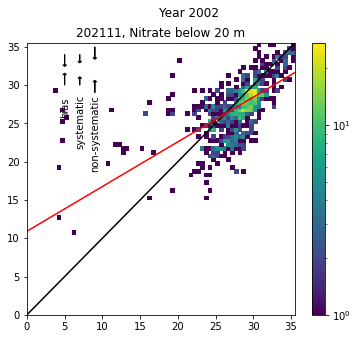

In [118]:
results = plot_one_only(2002)
results.style.format(myformat)

/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
202111,850,-0.77,2.3,0.11,0.27,6.8,1.3,2.0,0.18


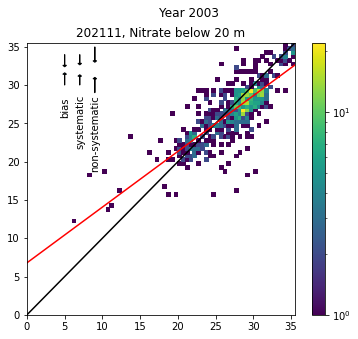

In [119]:
results = plot_one_only(2003)
results.style.format(myformat)

/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
202111,640,0.39,3.1,0.16,0.4,1.1e+01,1.8,2.5,0.39


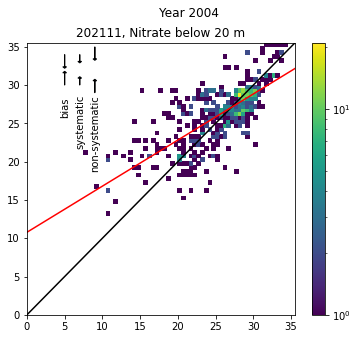

In [120]:
results = plot_one_only(2004)
results.style.format(myformat)

/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
202111,812,0.76,3.1,0.18,0.45,1.3e+01,2.1,2.3,0.44


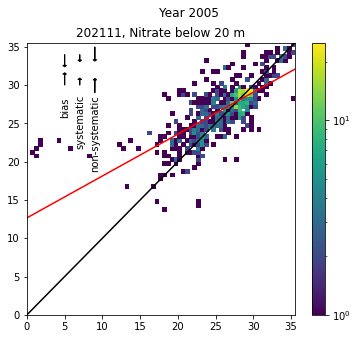

In [121]:
results = plot_one_only(2005)
results.style.format(myformat)

/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
202111,723,-0.14,2.7,0.17,0.4,1.1e+01,1.5,2.2,0.29


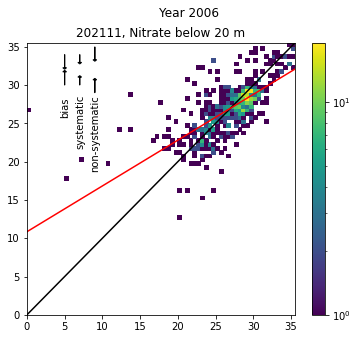

In [122]:
results = plot_one_only(2006)
results.style.format(myformat)

/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,827,-0.77,2.9,0.2,0.41,1.1e+01,1.7,2.4,0.25
202111,827,-0.66,2.8,0.19,0.39,1e+01,1.6,2.4,0.22


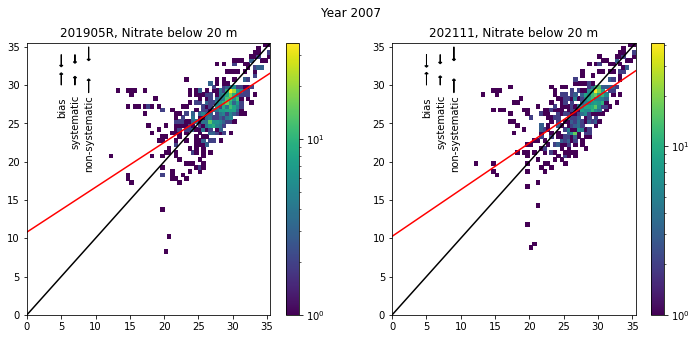

In [134]:
alltogether = plot_compare_year(2007)
alltogether.style.format(myformat).apply(highlight_max_min)

/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,788,-0.54,2.7,0.15,0.34,9.1,1.4,2.3,0.19
202111,788,-0.27,2.4,0.13,0.33,9.0,1.3,2.0,0.26


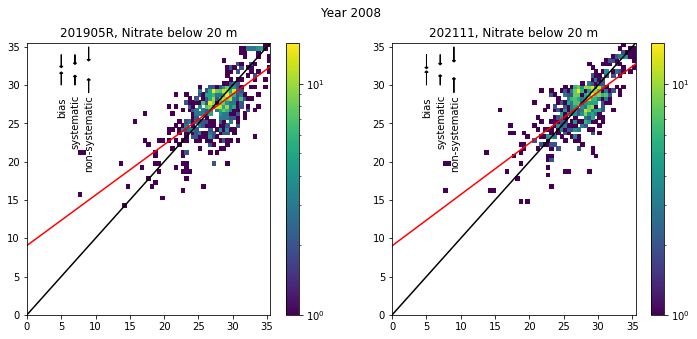

In [135]:
alltogether = plot_compare_year(2008)
alltogether.style.format(myformat).apply(highlight_max_min)

/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,818,-0.15,2.3,0.13,0.38,1e+01,1.4,1.8,0.36
202111,818,-0.61,2.2,0.12,0.33,8.7,1.4,1.8,0.32


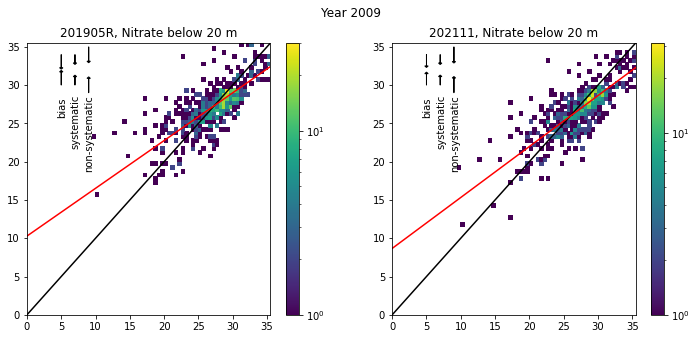

In [136]:
alltogether = plot_compare_year(2009)
alltogether.style.format(myformat).apply(highlight_max_min)

/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,1071,-0.79,2.4,0.11,0.33,8.5,1.6,1.8,0.48
202111,1071,-0.98,2.5,0.1,0.28,6.7,1.5,1.9,0.33


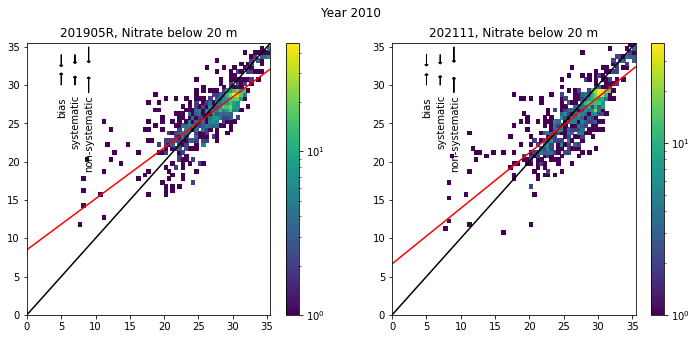

In [137]:
alltogether = plot_compare_year(2010)
alltogether.style.format(myformat).apply(highlight_max_min)

/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,896,-0.47,2.6,0.14,0.31,8.1,1.3,2.3,0.18
202111,896,-0.37,2.1,0.089,0.24,6.3,0.98,1.8,0.21


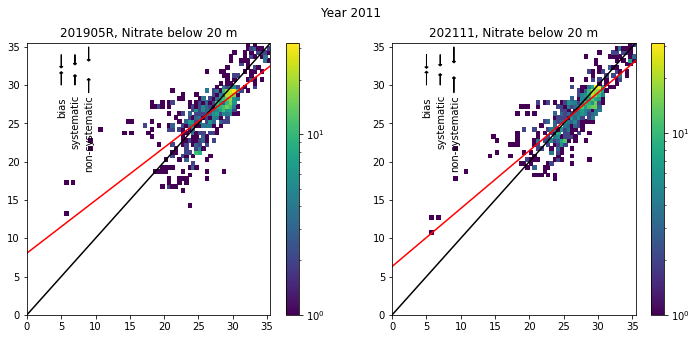

In [141]:
alltogether = plot_compare_year(2011)
alltogether.style.format(myformat).apply(highlight_max_min)

/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,929,-0.65,2.3,0.12,0.39,9.9,1.6,1.6,0.48
202111,929,-0.94,2.3,0.11,0.27,6.3,1.4,1.8,0.25


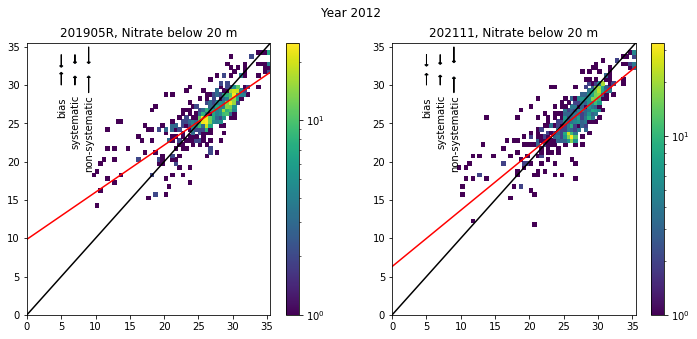

In [143]:
alltogether = plot_compare_year(2012)
alltogether.style.format(myformat).apply(highlight_max_min)

/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,671,-2.6,3.4,0.26,0.34,7.2,2.8,1.9,0.26
202111,671,-2.0,3.0,0.21,0.3,6.6,2.2,2.0,0.16


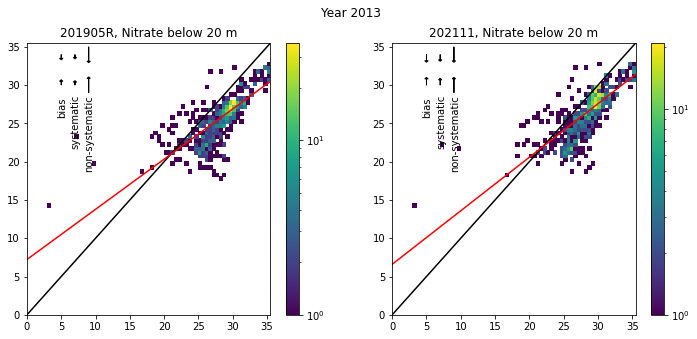

In [145]:
alltogether = plot_compare_year(2013)
alltogether.style.format(myformat).apply(highlight_max_min)

/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,1054,-2.9,3.6,0.17,0.29,5.2,3.2,1.7,0.35
202111,1054,-2.4,3.3,0.15,0.31,6.4,2.7,1.8,0.37


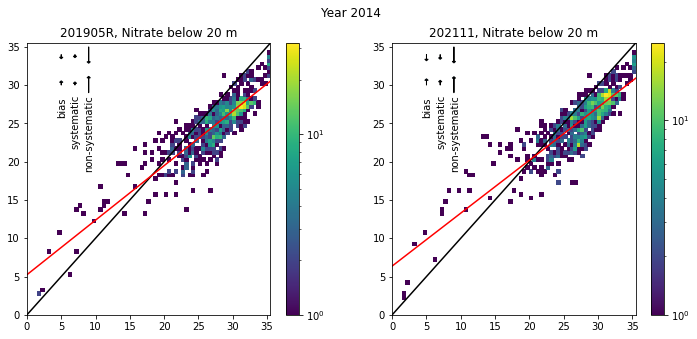

In [147]:
alltogether = plot_compare_year(2014)
alltogether.style.format(myformat).apply(highlight_max_min)

/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,392,-2.1,2.9,0.23,0.35,7.2,2.4,1.7,0.29
202111,392,-1.8,2.7,0.18,0.27,5.2,2.0,1.8,0.15


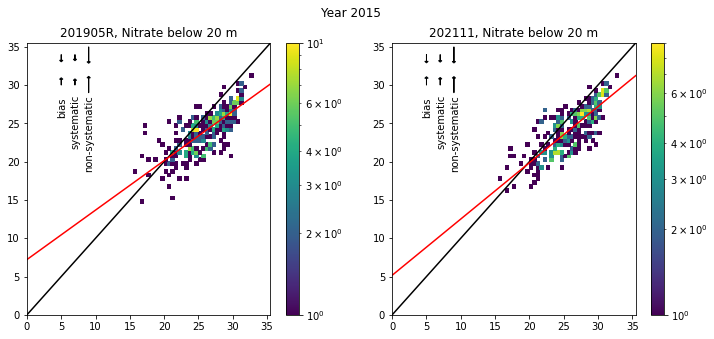

In [149]:
alltogether = plot_compare_year(2015)
alltogether.style.format(myformat).apply(highlight_max_min)

/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,7446,-1.2,2.8,0.16,0.35,8.5,1.8,2.2,0.3
202111,7446,-1.1,2.6,0.13,0.3,7.3,1.6,2.1,0.25


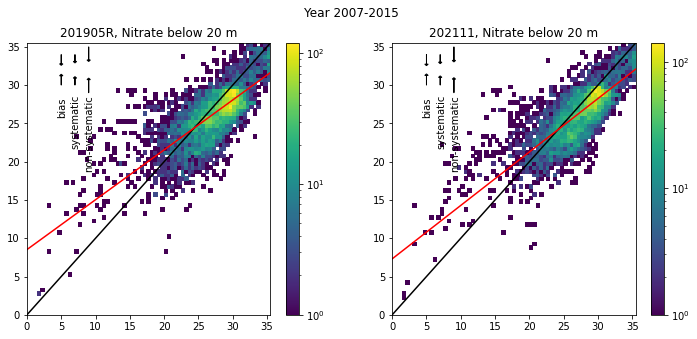

In [150]:
alltogether = plot_allyears(2015)
alltogether.style.format(myformat).apply(highlight_max_min)

In [24]:
pieces = ('/home/sallen/202007/202007G-p2/ObsModel_202007Gp2_bot_20150101_20151231.csv',
          '/home/sallen/202007/202007G-p2/ObsModel_202007Gp2f0_bot_20160101_20161231.csv',
       #   '/home/sallen/202007/202007G-p2/ObsModel_202007Gp2f0_bot_20170101_20171231.csv',
         '/home/sallen/202007/202007G-p2/ObsModel_202007Gp2_psf_20150101_20151231.csv',
#b          '/home/sallen/202007/202007C-p3/ObsModel_202007Cp3_psf_20160101_20161231.csv',
#b          '/home/sallen/202007/202007C-p3/ObsModel_202007Cp3_psf_20170101_20171231.csv',
         '/home/sallen/202007/202007G-p2/ObsModel_202007Gp2_pug_20150101_20151231.csv',
          '/home/sallen/202007/202007G-p2/ObsModel_202007Gp2f0_pug_20160101_20161231.csv',
  #        '/home/sallen/202007/202007G-p2/ObsModel_202007Gp2f0_pug_20170101_20171231.csv',
         '/home/sallen/202007/202007G-p2/ObsModel_202007Gp2_hplc_20150101_20151231.csv',
         '/home/sallen/202007/202007G-p2/ObsModel_202007Gp2f0_hplc_20160101_20161231.csv',
  #       '/home/sallen/202007/202007G-p2/ObsModel_202007Gp2f0_hplc_20170101_20171231.csv'
         )

21.38997868353431 441.4661096800038


/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
Gp2,1791,-1.7,3.1,0.13,0.25,4.7,2.0,2.4,0.17


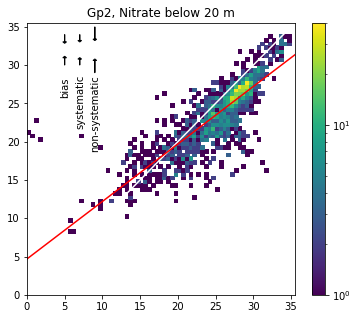

In [25]:
temp1 = read_pieces(pieces)
temp1['NO3'] = temp1.N.fillna(value=temp1.NO23).fillna(value=temp1['Nitrate_plus_Nitrite [umol/L]'])
modGp2 = plot_and_stats(temp1, 'Gp2', idepth, jdepth)
modGp2.style.format(myformat)

In [26]:
pieces = ('/data/sallen/results/MEOPAR/202111/ObsModel_202111_bot_20150101_20151231.csv',
         '/data/sallen/results/MEOPAR/202111/ObsModel_202111_psf_20150101_20151231.csv',
         '/data/sallen/results/MEOPAR/202111/ObsModel_202111_pug_20150101_20151231.csv',
         '/data/sallen/results/MEOPAR/202111/ObsModel_202111_hplc_20150101_20151231.csv',
         '/data/sallen/results/MEOPAR/202111/ObsModel_202111_bot_20160101_20161231.csv',
         '/data/sallen/results/MEOPAR/202111/ObsModel_202111_pug_20160101_20161231.csv',
         '/data/sallen/results/MEOPAR/202111/ObsModel_202111_hplc_20160101_20161231.csv'
         )

21.38997868353431 441.4661096800038


/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
modv202111,1791,-1.6,3.0,0.12,0.27,5.4,2.0,2.3,0.24


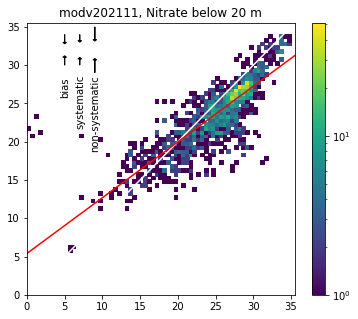

In [27]:
temp1 = read_pieces(pieces)
temp1['NO3'] = temp1.N.fillna(value=temp1.NO23).fillna(value=temp1['Nitrate_plus_Nitrite [umol/L]'])
modv202111 = plot_and_stats(temp1, 'modv202111', idepth, jdepth)
modv202111.style.format(myformat)

In [31]:
alltogether = pd.concat([d201812, d201905, 
                         dCp2, modCp3, #Dagain, DnoC, DlowR, 
                         modF, #modH, 
                         modGp1, modGp2,
                        modv202111], axis=0)
foramt = "{:.2}"
alltogether.style.format(myformat).apply(highlight_max_min)

,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
H201812,1793,-1.9,3.6,0.14,0.069,-0.11,1.9,3.1,-0.3
H201905,1793,-1.9,3.3,0.14,0.27,5.0,2.3,2.3,0.22
Cp2,1793,-2.4,3.6,0.15,0.19,2.3,2.6,2.6,0.039
Cp3,1789,-2.6,3.7,0.16,0.16,1.4,2.7,2.6,-0.015
F,1791,-2.1,3.4,0.15,0.27,4.7,2.5,2.4,0.2
Gp1,1791,-1.7,3.1,0.13,0.24,4.4,2.0,2.4,0.16
Gp2,1791,-1.7,3.1,0.13,0.25,4.7,2.0,2.4,0.17
modv202111,1791,-1.6,3.0,0.12,0.27,5.4,2.0,2.3,0.24


**Conclusion** Gp1 has the best nitrate!  Gp2 very very similar. Fuzz with low model values and obs between 25 and 30 is Puget.

## Question 1: Is the inclusion of Puget Sound why the nitrate is so underpredicted?

In [28]:
pieces = ('/home/sallen/202007/202007F/ObsModel_202007F_bot_20150101_20151231.csv',
          '/home/sallen/202007/202007F/ObsModel_202007F_bot_20160101_20161231.csv',
          '/home/sallen/202007/202007F/ObsModel_202007F_bot_20170101_20171231.csv',
         '/home/sallen/202007/202007F/ObsModel_202007F_psf_20150101_20151231.csv',
#          '/home/sallen/202007/202007F/ObsModel_202007F_psf_20160101_20161231.csv',
#          '/home/sallen/202007/202007F/ObsModel_202007F_psf_20170101_20171231.csv',
#         '/home/sallen/202007/202007F/ObsModel_202007F_pug_20150101_20151231.csv',
#          '/home/sallen/202007/202007F/ObsModel_202007F_pug_20160101_20161231.csv',
#          '/home/sallen/202007/202007F/ObsModel_202007F_pug_20170101_20171231.csv',
         '/home/sallen/202007/202007F/ObsModel_202007F_hplc_20150101_20151231.csv',
         '/home/sallen/202007/202007F/ObsModel_202007F_hplc_20160101_20161231.csv',
         '/home/sallen/202007/202007F/ObsModel_202007F_hplc_20170101_20171231.csv')

21.38997868353431 441.4661096800038


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
F,2429,-1.6,2.6,0.11,0.25,5.0,1.9,1.8,0.26


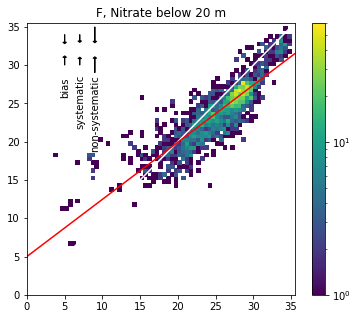

In [29]:
temp1 = read_pieces(pieces)
temp1['NO3'] = temp1.N.fillna(value=temp1.NO23).fillna(value=temp1['Nitrate_plus_Nitrite [umol/L]'])
modF = plot_and_stats(temp1, 'F', idepth, jdepth)
modF.style.format(myformat)

It makes it worse, but the maximum number of points (yellow patch) is not Puget Sound.

## Question 2: Is the bias improving or getting worse in time?

In [34]:
#temp1.set_index('dtUTC', inplace=True)
temp1.index = pd.to_datetime(temp1.index)

21.38997868353431 441.4661096800038


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
F15,392,-2.3,3.0,0.22,0.29,5.4,2.5,1.6,0.23


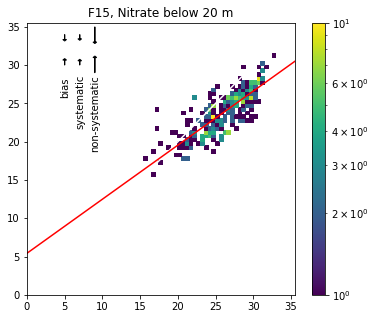

In [38]:
modF15 = plot_and_stats(temp1[temp1.index < dt.datetime(2016, 1, 1)], 'F15', idepth, jdepth)
modF15.style.format(myformat)

21.38997868353431 441.4661096800038


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
F16,1072,-1.7,2.5,0.096,0.16,2.7,1.8,1.7,0.14


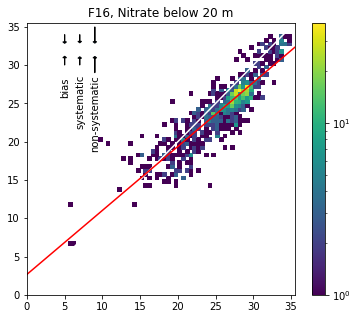

In [40]:
modF16 = plot_and_stats(temp1[(temp1.index >= dt.datetime(2016, 1, 1)) & (temp1.index < dt.datetime(2017, 1, 1))], 'F16', idepth, jdepth)
modF16.style.format(myformat)

21.38997868353431 441.4661096800038


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
F17,965,-1.2,2.7,0.1,0.31,6.7,1.9,1.9,0.36


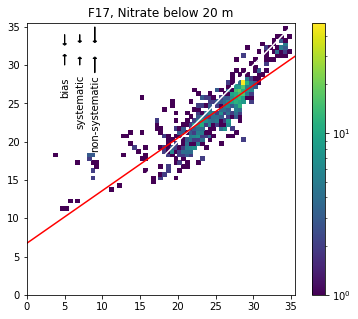

In [41]:
modF17 = plot_and_stats(temp1[temp1.index >= dt.datetime(2017, 1, 1)], 'F17', idepth, jdepth)
modF17.style.format(myformat)

Bias is improving in time.